<a href="https://colab.research.google.com/github/EricCallaway/COSC_6319_Project/blob/NavyaMakkena_COSC_6319_Project/model_implementation_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
!pip install datasets

In [3]:
!pip install contractions

Loading dataset from transformers datasets

In [4]:
from datasets import load_dataset

dataset = load_dataset("csebuetnlp/xlsum",'english')
train_report, train_summary, val_report, val_summary, test_report, test_summary = dataset['train']['text'][:100], dataset['train']['summary'][:100],dataset['validation']['text'][:100], dataset['validation']['summary'][:100],dataset['test']['text'], dataset['test']['summary']
print(len(train_report))
print(len(train_summary))
print(len(val_report))
print(len(val_summary))
print(len(test_report))
print(len(test_summary))
print(train_report[:10])


Reusing dataset xlsum (/root/.cache/huggingface/datasets/csebuetnlp___xlsum/english/2.0.0/518ab0af76048660bcc2240ca6e8692a977c80e384ffb18fdddebaca6daebdce)


  0%|          | 0/3 [00:00<?, ?it/s]

100
100
100
100
11535
11535
['The Met Office has issued a yellow weather warning for wind covering Wales and England, starting from 21:00 GMT on Wednesday evening. Travel and power are both likely to be disrupted, with the warning to remain in place until 15:00 on Thursday. Gusts of 55mph (88kmh) are likely and could hit up to 70mph on coasts and hills, with heavy and blustery showers.', 'Atlantis Resources unveiled the marine energy device at Invergordon ahead of it being shipped to Kirkwall. Trials on the device will now be run at the European Marine Energy Centre test site off Eday. The device stands 22.5m (73ft) tall, weighs 1,300 tonnes and has two sets of blades on a single unit. It could generate enough power for 1,000 homes.', 'Police were called to the scene outside the Coral shop on Compton Road in Harehills just before 14:00 BST. The man was taken to hospital for treatment but his condition is not known. West Yorkshire Police said the area has been cordoned off and officers 

Preprocessing data

In [5]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import contractions
from nltk.stem import WordNetLemmatizer

def text_lowercase(text):
    return text.lower()

def remove_numbers(text):
    output_text = re.sub(r'\d+', '', text)
    return output_text

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_whitespace(text):
    return  text.strip()

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = " ".join([word for word in str(text).split() if word not in stop_words])
    return filtered_text

def remove_html(dataText):
    return BeautifulSoup(dataText, "lxml").text

def contraction_mapping(text):
    expanded_words = []   
    for word in text.split():
    # using contractions.fix to expand the shortened words
      expanded_words.append(contractions.fix(word))  
    expanded_text = ' '.join(expanded_words)
    return expanded_text

def lemmatization(text):
   lemmatizer = WordNetLemmatizer()
   return " ".join([lemmatizer.lemmatize(word) for word in text.split()])



def cleaning_data(content):
    # Lowercase text
    content = text_lowercase(content)

    # Remove numbers
    content = remove_numbers(content)

    # remove punctuation
    content = remove_punctuation(content)

    # remove whitespace from text
    content = remove_whitespace(content)

    # remove html from string
    content = remove_html(content)

    # contraction mapping
    content = contraction_mapping(content)

    # remove stopwords
    content = remove_stopwords(content)

    # lemmatization
    content = lemmatization(content)
    return content

for i in range(len(train_report)):
    train_report[i] = cleaning_data(train_report[i])

for j in range(len(train_summary)):
    train_summary[j] = cleaning_data(train_summary[j])
    train_summary[j] = 'sostoken ' + train_summary[j]+ ' eostoken'

for k in range(len(val_report)):
    val_report[k] = cleaning_data(val_report[k])
    
for l in range(len(val_summary)):
    val_summary[l] = cleaning_data(val_summary[l])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


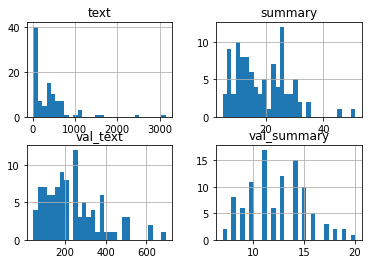

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
text_word_count = []
summary_word_count = []
val_text_word_count = []
val_summary_word_count = []

# populate the lists with sentence lengths
for i in range(len(train_report)):
      text_word_count.append(len(train_report[i].split()))

for i in range(len(train_summary)):
      summary_word_count.append(len(train_summary[i].split()))

# populate the lists with sentence lengths
for i in range(len(val_report)):
      val_text_word_count.append(len(val_report[i].split()))

for i in range(len(val_summary)):
      val_summary_word_count.append(len(val_summary[i].split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count,'val_text':val_text_word_count, 'val_summary':val_summary_word_count})
length_df.hist(bins = 30)
plt.show()

max_len_arcticles = 1500 # fixing max length for articles
max_len_summary = 50 # fixing max length for summaries


Tokenise using kera's tokenizer

In [7]:
from keras.preprocessing.text import Tokenizer
VOCAB_SIZE = 50000
article_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
# articles
article_tokenizer.fit_on_texts(train_report)
article_sequences = article_tokenizer.texts_to_sequences(train_report)
art_word_index = article_tokenizer.word_index
print(len(art_word_index))
# summaries
summary_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
summary_tokenizer.fit_on_texts(train_summary)
summary_sequences = summary_tokenizer.texts_to_sequences(train_summary)
summary_word_index = summary_tokenizer.word_index
print(len(summary_word_index))

# validation articles
val_art_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
val_art_tokenizer.fit_on_texts(val_report)
validation_article_sequences = val_art_tokenizer.texts_to_sequences(val_report)
val_art_word_index = val_art_tokenizer.word_index
print(len(val_art_word_index))
# validation_summaries
val_summary_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
val_summary_tokenizer.fit_on_texts(val_summary)
validation_summary_sequences = val_summary_tokenizer.texts_to_sequences(val_summary)
val_sum_word_index = val_summary_tokenizer.word_index
print(len(val_sum_word_index))




8827
1185
6106
937


Padding using kera's pad_sequence to longest sequence length

In [8]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

pad_art_sequences = pad_sequences(article_sequences, maxlen=max_len_arcticles, padding='post', truncating='post')
pad_sum_sequences = pad_sequences(summary_sequences, maxlen=max_len_summary, padding='post', truncating='post')

pad_validation_art_sequences = pad_sequences(validation_article_sequences, maxlen=max_len_arcticles, padding='post', truncating='post')
pad_validation_sum_sequences = pad_sequences(validation_summary_sequences, maxlen=max_len_summary, padding='post', truncating='post')

print(pad_art_sequences)
print(pad_art_sequences.shape)
print(pad_sum_sequences.shape)
print(pad_validation_art_sequences.shape)
print(pad_validation_sum_sequences.shape)



[[ 865  221 1739 ...    0    0    0]
 [4203 2868 2869 ...    0    0    0]
 [ 181  168  790 ...    0    0    0]
 ...
 [8594 8595 1634 ...    0    0    0]
 [4188 8644   17 ...    0    0    0]
 [ 622  179   26 ...    0    0    0]]
(100, 1500)
(100, 50)
(100, 1500)
(100, 50)


Using Pre trained gloVe for word embeddings

In [9]:
import numpy as np

embeddings_index = {}
with open('/content/drive/My Drive/Colab Notebooks/glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix for articles
article_embedding_matrix = np.zeros(((len(art_word_index)+1), embedding_dim))
for word, i in art_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        article_embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(article_embedding_matrix.shape)

# Prepare embedding matrix for summaries
hits=0
misses = 0
summary_embedding_matrix = np.zeros((len(summary_word_index) + 1, embedding_dim))
for word, j in summary_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        summary_embedding_matrix[j] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(summary_embedding_matrix.shape)

Found 400001 word vectors.
Converted 8223 words (604 misses)
(8828, 200)
Converted 1153 words (32 misses)
(1186, 200)


Loading embeddings matrix to embedding layer

In [10]:
from keras.layers import Embedding
import keras.initializers

encoder_embedding_layer = Embedding(
    input_dim = article_embedding_matrix.shape[0], #num_distinct_words
    output_dim = embedding_dim, #embedding_output_dims
    input_length = max_len_arcticles, #max_sequence_length
    embeddings_initializer= keras.initializers.Constant(article_embedding_matrix),
    trainable = True
)

decoder_embedding_layer = Embedding(
    input_dim = summary_embedding_matrix.shape[0],
    output_dim = embedding_dim,
    input_length = max_len_summary,
    embeddings_initializer= keras.initializers.Constant(summary_embedding_matrix),
    trainable = True
)

Build Model

In [34]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense,LSTM,Dropout,Input,Activation,Bidirectional

# Input layer
encoder_input = layers.Input(shape=(max_len_arcticles,))
encoder_embedded = encoder_embedding_layer(encoder_input)

# Decoder -- LSTM
decoder_input = layers.Input(shape=(None,))
decoder_embedded = decoder_embedding_layer(decoder_input)

# Encoder 1 -- Bidirectional LSTM 1
encoder1_output, forward_h1, forward_c1 ,backward_h1, backward_c1= Bidirectional(layers.LSTM(200, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.2,name="encoder1"),merge_mode="concat")(
    encoder_embedded
)
# Encoder 2 -- Bidirectional LSTM 2
encode2_output, forward_h2, forward_c2 ,backward_h2, backward_c2= Bidirectional(layers.LSTM(200, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.2,name="encoder2"),merge_mode="concat")(
    encoder1_output,initial_state=[forward_h1,backward_h1,forward_c1,backward_c1]
)
state_h2 =  layers.Concatenate()([forward_h2, backward_h2])
state_c2 =  layers.Concatenate()([forward_c2, backward_c2])
encoder2_state = [state_h2,state_c2]

# Pass the encoder 2 state to decoder LSTM layer, as initial state
decoder_LSTM= layers.LSTM(400, dropout=0.2,recurrent_dropout=0.2,name="decoder")
decoder_output = decoder_LSTM(
    decoder_embedded, initial_state=encoder2_state
)
# Dense layer with activation
decoder_dense = layers.Dense(50,activation='softmax')
output = decoder_dense(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1500)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1500, 200)    1765600     ['input_3[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  [(None, 1500, 400),  641600     ['embedding[1][0]']              
 )                               (None, 200),                                                     
                                 (None, 200),                                                     
                                 (None, 200),                                               

Compiling Model

In [37]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.005), loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Accuracy(),get_f1])

Training model

In [38]:
print(pad_art_sequences.shape)
print(pad_sum_sequences.shape)
print(pad_validation_art_sequences.shape)
print(pad_validation_sum_sequences.shape)

history = model.fit(  [pad_art_sequences,pad_sum_sequences], 
                      pad_sum_sequences.reshape(pad_sum_sequences.shape[0],pad_sum_sequences.shape[1], 1)  ,
                      epochs=50,
                      batch_size = 50,
                     # callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
                      validation_data =([pad_validation_art_sequences,pad_validation_sum_sequences], pad_validation_sum_sequences.reshape(pad_validation_sum_sequences.shape[0],pad_validation_sum_sequences.shape[1], 1))
                     )
print(history.params)


(100, 1500)
(100, 50)
(100, 1500)
(100, 50)
Epoch 1/50
2/2 [==============================] - 63s 28s/step - loss: 28259.0898 - categorical_accuracy: 0.0400 - accuracy: 0.0000e+00 - get_f1: 1.5947 - val_loss: 15439.3477 - val_categorical_accuracy: 0.0500 - val_accuracy: 0.0000e+00 - val_get_f1: 1.8197
Epoch 2/50
2/2 [==============================] - 50s 30s/step - loss: 26722.6270 - categorical_accuracy: 0.0600 - accuracy: 0.0000e+00 - get_f1: 1.6007 - val_loss: 15233.3672 - val_categorical_accuracy: 0.0300 - val_accuracy: 0.0000e+00 - val_get_f1: 1.8261
Epoch 3/50
2/2 [==============================] - 48s 28s/step - loss: 27276.3906 - categorical_accuracy: 0.0100 - accuracy: 0.0000e+00 - get_f1: 1.5872 - val_loss: 15301.5400 - val_categorical_accuracy: 0.1200 - val_accuracy: 0.0000e+00 - val_get_f1: 1.8198
Epoch 4/50
2/2 [==============================] - 50s 29s/step - loss: 27277.3809 - categorical_accuracy: 0.0600 - accuracy: 0.0000e+00 - get_f1: 1.5696 - val_loss: 14822.7109 - v

Visualization of metrics

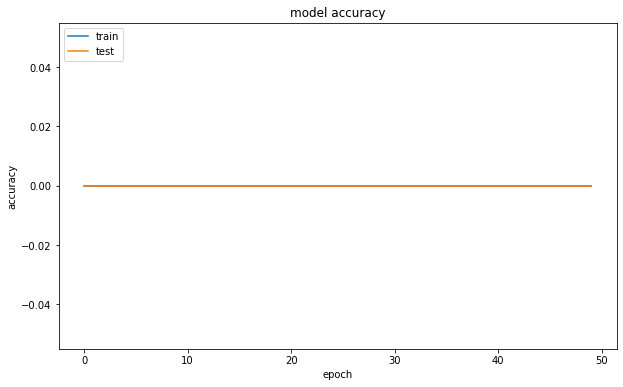

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

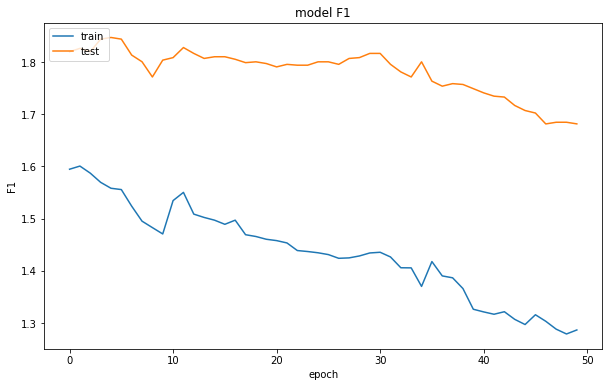

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('model F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

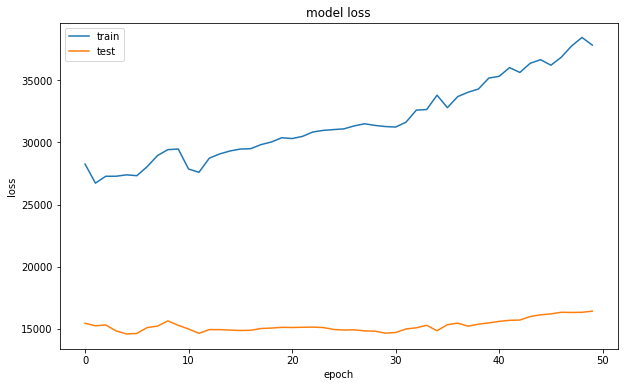

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluate model using Validation dataset

In [42]:
test_results = model.evaluate((pad_validation_art_sequences,pad_validation_sum_sequences),
                              pad_validation_sum_sequences,
                              batch_size=50
                              )
print(test_results)

2/2 [==============================] - 9s 4s/step - loss: 16412.5371 - categorical_accuracy: 0.0500 - accuracy: 0.0000e+00 - get_f1: 1.6815
[16412.537109375, 0.05000000074505806, 0.0, 1.6815342903137207]


Model testing and getting summaries for test data

In [44]:
reverse_target_word_index= summary_tokenizer.index_word
reverse_source_word_index= article_tokenizer.index_word
target_word_index=summary_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = keras.Model(inputs=encoder_input,outputs=[encode2_output, state_h2, state_c2])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(max_len_summary,))
decoder_state_input_c = Input(shape=(max_len_summary,))
#decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
decoder_embedded = decoder_embedding_layer(decoder_input)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h3, state_c3 = decoder_LSTM(decoder_embedded, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = keras.Model(
    [decoder_input] + [decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h3, state_c3])


def conversion_to_wordsummary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostoken']) and i!=target_word_index['eostoken']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def conversion_to_articletext(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

def decode_sequence(input_seq):
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostoken']
    decoded_sentence = ''
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

for i in range(0,10):
    print("Article:",conversion_to_articletext(pad_art_sequences[i]))
    print("Original summary:",conversion_to_wordsummary(pad_sum_sequences[i]))
    print("Predicted summary:",decode_sequence(pad_art_sequences[i].reshape(1,max_len_arcticles)))
    print("\n")

ValueError: ignored

In [33]:
target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
target_seq[0, 0] = target_word_index['sostoken']
print(target_seq)

[[2.]]
